# Sale Price Study 


## Objectives


The objective here is to start addressing the business requirements. So my plan is to display how a houses attributes can influence the market value of said house. 


## CRISP-DM


"Data Understanding"


In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/datacollection/HousePrices.csv"))
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


In [5]:
# We will now conduct an exploratory data analysis (EDA). This will give us a better insight into our DataFrame. 

import pandas_profiling
pandas_report = pandas_profiling.ProfileReport(df, minimal=True)
pandas_report.to_notebook_iframe()

/tmp/ipykernel_1403/873145365.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation study

- This is conducted to analyse missing data which will be potentially useful for the Data Cleaning step. 

In [6]:
vars_with_missing_data = df[df.columns[df.isna().sum() > 0 ]]
vars_with_missing_data

,2ndFlrSF,BedroomAbvGr,BsmtFinType1,EnclosedPorch,GarageFinish,GarageYrBlt,LotFrontage,MasVnrArea,WoodDeckSF
0,854.0,3.0,GLQ,0.0,RFn,2003.0,65.0,196.0,0.0
1,0.0,3.0,ALQ,NaN,RFn,1976.0,80.0,0.0,NaN
2,866.0,3.0,GLQ,0.0,RFn,2001.0,68.0,162.0,NaN
3,NaN,NaN,ALQ,NaN,Unf,1998.0,60.0,0.0,NaN
4,NaN,4.0,GLQ,0.0,RFn,2000.0,84.0,350.0,NaN
...,...,...,...,...,...,...,...,...,...
1455,694.0,3.0,Unf,NaN,RFn,1999.0,62.0,0.0,0.0
1456,0.0,NaN,ALQ,NaN,Unf,1978.0,85.0,119.0,NaN
1457,1152.0,4.0,GLQ,NaN,RFn,1941.0,66.0,0.0,NaN
1458,0.0,2.0,NaN,112.0,Unf,1950.0,68.0,0.0,NaN


In [7]:
missing_var = vars_with_missing_data.select_dtypes(include="object").columns.tolist()

missing_var


['BsmtFinType1', 'GarageFinish']

In [8]:
from sklearn.impute import SimpleImputer

# Create an imputer object by imputing the most frequest category
categorical_imputer = SimpleImputer(strategy="most_frequent")

# Apply the imputer to the variable for missing values 
df[missing_var] = categorical_imputer.fit_transform(df[missing_var])

In [9]:
df[missing_var].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtFinType1  1460 non-null   object
 1   GarageFinish  1460 non-null   object
dtypes: object(2)
memory usage: 22.9+ KB


In [10]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd 

# Select only object (categorical) columns for encoding

categorical_cols = df.select_dtypes(include='object').columns
encoder = OneHotEncoder(sparse=False, drop=None)
encoded_array = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))
df_ohe = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

# Check the new dataframe's shape and look at the first few rows
print(df_ohe.shape)
df_ohe.head(3)

(1460, 40)


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageYrBlt,GrLivArea,LotArea,...,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,856,854.0,3.0,706,150,0.0,548,2003.0,1710,8450,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1262,0.0,3.0,978,284,NaN,460,1976.0,1262,9600,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,920,866.0,3.0,486,434,0.0,608,2001.0,1786,11250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# Investigating correlation

corr_spearman = df_ohe.corr(method='spearman')
corr_spearman_saleprice = corr_spearman['SalePrice'].copy()
corr_spearman_sorted = corr_spearman_saleprice.reindex(corr_spearman_saleprice.abs().sort_values(ascending=False).index)
top_10_corr_spearman = corr_spearman_sorted[1:11]
top_10_corr_spearman

OverallQual       0.809829
GrLivArea         0.731310
YearBuilt         0.652682
GarageArea        0.649379
TotalBsmtSF       0.602725
GarageYrBlt       0.593788
KitchenQual_TA   -0.581803
1stFlrSF          0.575408
YearRemodAdd      0.571159
KitchenQual_Gd    0.478583
Name: SalePrice, dtype: float64

In [12]:

corr_pearson = df_ohe.corr(method='pearson')
corr_pearson_saleprice = corr_pearson['SalePrice'].copy()
corr_pearson_sorted = corr_pearson_saleprice.reindex(corr_pearson_saleprice.abs().sort_values(ascending=False).index)
top_10_corr_pearson = corr_pearson_sorted[1:11]
top_10_corr_pearson

OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
GarageYrBlt       0.486362
Name: SalePrice, dtype: float64

In [13]:
# Here we will delve deeper into the correlations

top_n = 5

# This code is not mine. It's taken from the Churnometer walkthrough project. 

set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())


{'1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF'}

In [14]:
features_to_analyze = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF']
features_to_analyze 

['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF']

In [15]:
df_eda = df.filter(features_to_analyze + ["SalePrice"]).copy()
df_eda.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,SalePrice
0,856,854.0,3.0,706,150,208500
1,1262,0.0,3.0,978,284,181500
2,920,866.0,3.0,486,434,223500


In [16]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
discretiser = EqualFrequencyDiscretiser(q=6, variables=["SalePrice"])
df_eda_transformed = discretiser.fit_transform(df_eda)
df_eda_transformed

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,SalePrice
0,856,854.0,3.0,706,150,4
1,1262,0.0,3.0,978,284,3
2,920,866.0,3.0,486,434,4
3,961,NaN,NaN,216,540,2
4,1145,NaN,4.0,655,490,5
...,...,...,...,...,...,...
1455,953,694.0,3.0,0,953,3
1456,2073,0.0,NaN,790,589,4
1457,1188,1152.0,4.0,275,877,5
1458,1078,0.0,2.0,49,0,2


In [17]:
# Creates bins or intervals.

discretiser.binner_dict_['SalePrice']

[-inf, 118500.0, 139700.0, 163000.0, 190000.0, 241416.66666666663, inf]

In [18]:
# Here we are making labels. 

labels = discretiser.binner_dict_["SalePrice"]
n_factor = len(labels) - 1 

labels_map = {
    n: (
        f"< {labels[1]}" if n == 0 else
        f"+{labels[n]}" if n < n_factor -1 else
        f"{labels[n]} to - {labels[n + 1]}"
    )
    for n in range(n_factor)
}

labels_map

{0: '< 118500.0',
 1: '+118500.0',
 2: '+139700.0',
 3: '+163000.0',
 4: '+190000.0',
 5: '241416.66666666663 to - inf'}

In [19]:
# Any unmapped values stay as they are.

df_eda["SalePrice"] = df_eda["SalePrice"].map(labels_map).fillna(df_eda["SalePrice"])
df_eda

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,SalePrice
0,856,854.0,3.0,706,150,208500
1,1262,0.0,3.0,978,284,181500
2,920,866.0,3.0,486,434,223500
3,961,NaN,NaN,216,540,140000
4,1145,NaN,4.0,655,490,250000
...,...,...,...,...,...,...
1455,953,694.0,3.0,0,953,175000
1456,2073,0.0,NaN,790,589,210000
1457,1188,1152.0,4.0,275,877,266500
1458,1078,0.0,2.0,49,0,142125


In [20]:
# Here we will use the Seaborn library for data visualization. Hue variable will be used to color data points by a categorical variable. 

hue_order = labels_map.values()
list(hue_order)

['< 118500.0',
 '+118500.0',
 '+139700.0',
 '+163000.0',
 '+190000.0',
 '241416.66666666663 to - inf']

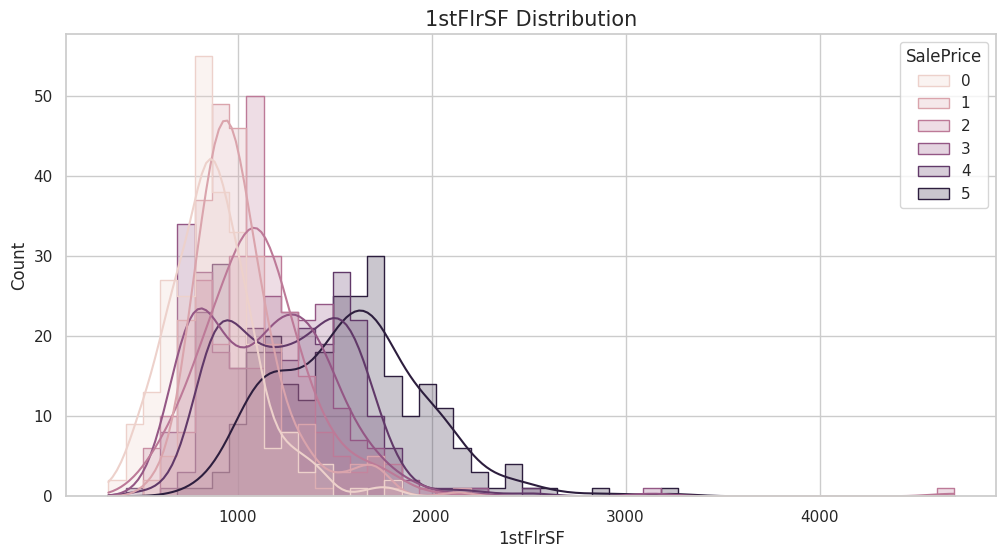

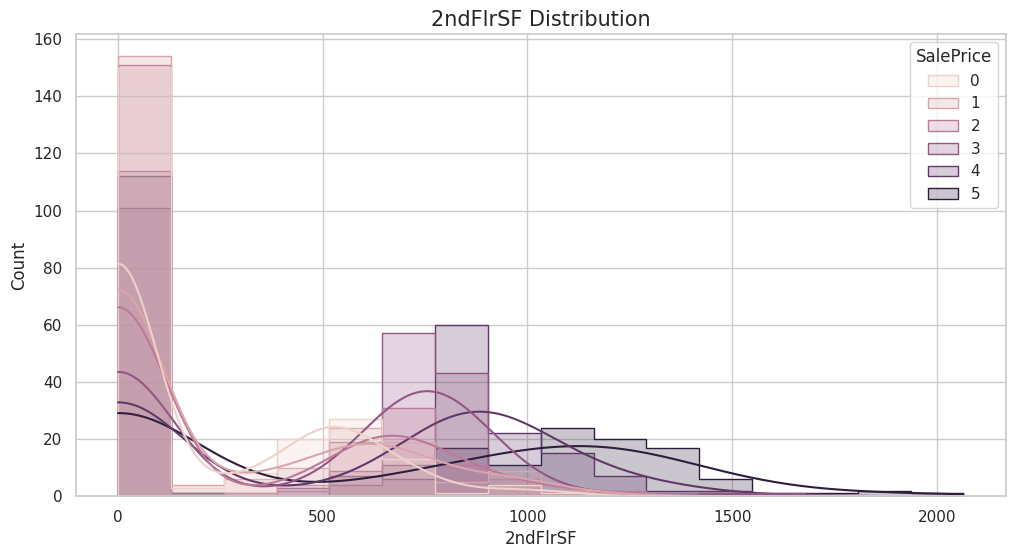

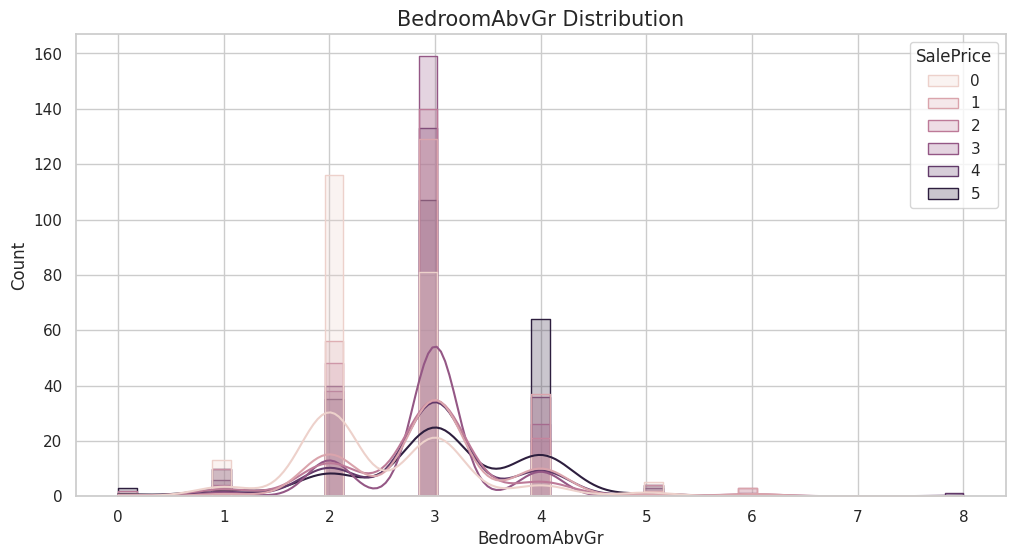

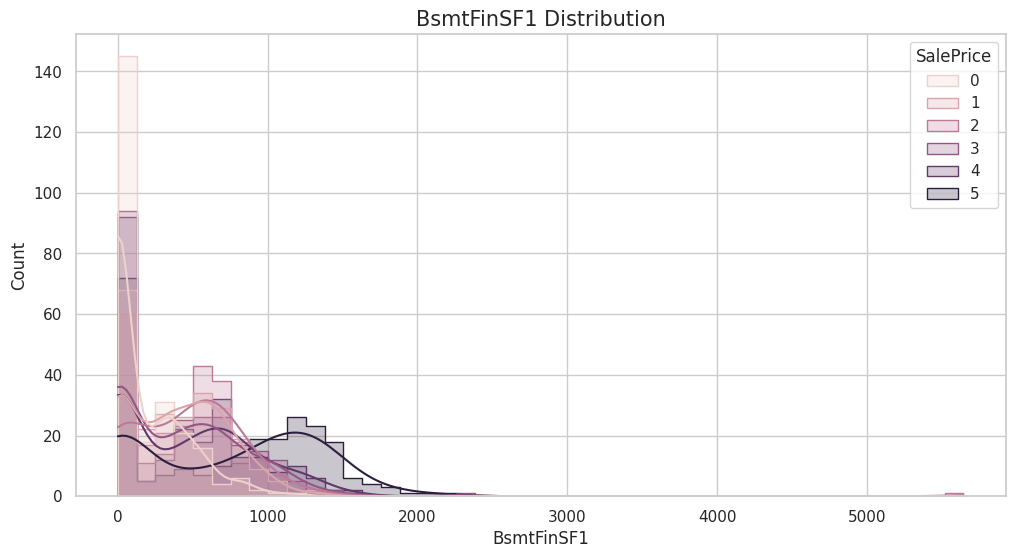

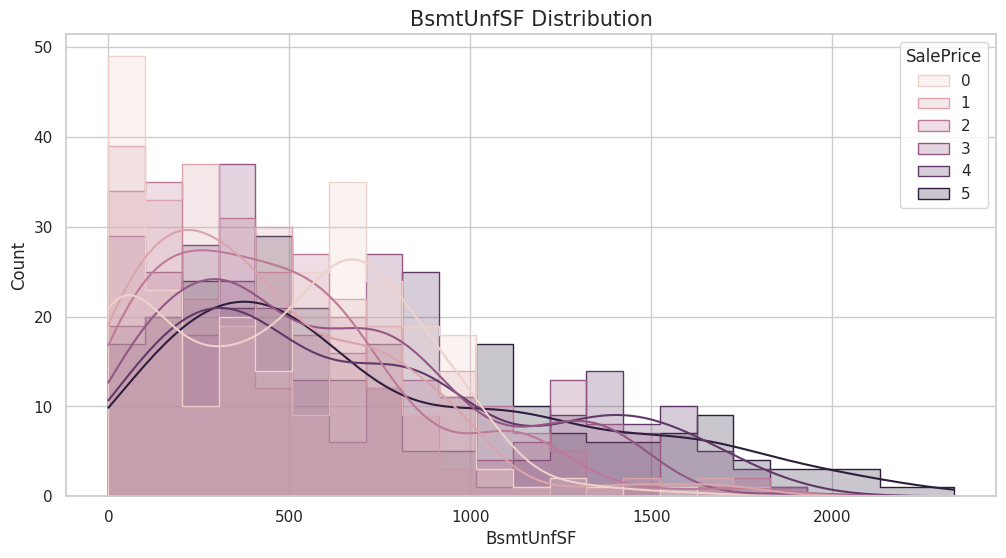

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

# Set seaborn style for plots
sns.set(style="whitegrid")

# Function to plot numerical columns against target variables
def plot_numerical_distribution(df, column, target_var, hue_order):
    if is_numeric_dtype(df[column]):
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.histplot(df, x=column, hue=target_var, hue_order=hue_order, kde=True, element="step", ax=ax)
        ax.set_title(f"{column} Distribution", fontsize=15)
        plt.show()
    else:
        print(f"Column '{column}' is not numerical and will be plotted.")

# Define the target variable and columns to plot
target_var = "SalePrice"
numeric_columns = ["1stFlrSF", "2ndFlrSF", "BedroomAbvGr", "BsmtFinSF1", "BsmtUnfSF"]

# Iterate over the selected columns and plot
for column in numeric_columns:
    plot_numerical_distribution(df_eda_transformed, column, target_var, hue_order=hue_order)
    print("\n\n")